In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Hyper parameters:
N=50 # Number of data points

What do support vector machines think data looks like?
To answer that question, I generate data from a support vector machine in this notebook. Of course, SVMs are not typically seen as generative models, but Peter Sollich suggests a bayesian interpretation of SVMs, and we sample from his model (see http://web.cs.iastate.edu/~honavar/bayes-svm.pdf). 

We're considering binary classification: classifying the elements of a set $S$ as either red or blue.

To summarize, his model uses the following (prior) ingredients:
* A set $S$ of points to be classified. (In our example, $S=[0,1]^2$ will be be the unit square).
* A probability distribution $p_S(s)$ encoding the prior odds with which an element $s\in S$ might be observed (we will return to this later, but in our example, it will be the uniform distribution).
* A Gaussian process, with kernel $k(x,y), \quad x,y\in S,$ defining a prior probability distribution $p(\theta)$ on classifying functions $\theta:S\to \mathbb{R}$: if $\theta(s)>0$, then $s$ is likely to be red, and if $\theta(s)<0$, then $s$ is likely to be blue. (In our example, we use the sum of a gaussian kernel and white noise, we list various kernels below...). 

In [2]:
loc_scale = .25
val_scale = 3

gauss_kernel = lambda x,y: \
val_scale*np.exp((2*x.dot(y.T)-(np.sum(x**2,axis=1))[:,np.newaxis]
        -(np.sum(y**2,axis=1))[np.newaxis,:])/loc_scale**2)

In [3]:
val_scale = 3
linear_kernel = lambda x,y: val_scale * x.dot(y.T)

In [4]:
variance_per_degree = [5,1,.3,.1,.03,.01]
poly_kernel = lambda x,y:  sum(v*(x**i).dot((y**i).T) for i,v in enumerate(variance_per_degree))

In [5]:
mixed_kernel = lambda x,y: gauss_kernel(x,y)+linear_kernel(x,y)

In [6]:
noise_variance = 0.01

kernel = lambda x,y : gauss_kernel(x,y) \
        + (np.identity(x.shape[0])*noise_variance if x is y else 0)


In more detail, given a function $\theta:S\to\mathbb{R}$, the log odds that a specific point $s\in S$ is likely to be observed red is proportional to $-l(\theta(s)),$ where 
$$l(x)=\begin{cases} 1-z&\text{if } x<1\\0&\text{otherwise.}\end{cases}$$
is the hinge loss function, plotted below:

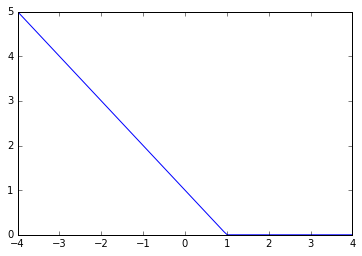

In [7]:
l = lambda z: np.maximum(1-z,0)
x = np.linspace(-3,3,100)
plt.plot(x,l(x))

* The final ingredient is the proportionality constant, $C>0$ of those log-odds.

In [8]:
# Hyperparameters:
C=1.5

In more detail, given a function $\theta:S\to \mathbb{R}$, the prior odds that a specific point $s\in S$ be observed red are proportional to
$$p(\text{red}\mid s,\theta)\propto e^{-C l(\theta(s))}.$$

So the odds that a specific point $s$ be observed red are proportional to 
$$p(\text{red},\theta\mid s)=p(\text{red}\mid s,\theta)p(\theta)\propto  e^{-C l(\theta(s))}p(\theta).$$

Similarly the log likelyhood of a set of observations $\mathcal{D}=\{(s_1,y_1),\dots,(s_n,y_n)\}$, where $$y_i=\begin{cases}1&\text{ if }s_i\in S\text{ is observed red.}\\-1&\text{ if }s_i\in S\text{ is observed blue.}\end{cases}$$

is $$p(\mathcal{D}\mid s_1,\dots,s_n;\theta)\propto \prod_{i=1}^n e^{-C l(y_i \theta(s_i))}$$

and $$p(\theta\mid\mathcal{D})\propto p(\mathcal{D}\mid s_1,\dots,s_n;\theta)p(\theta) \propto p(\theta)\prod_{i=1}^n e^{-C l(y_i \theta(s_i))}.$$

In particular, the MAP estimate for $\theta$ maximizes:

$$\frac{1}{2}\lVert\theta\rVert^2_{k^{-1}} +C\sum_{i=1}^n l(y_i \theta(s_i)),$$
where $k^{-1}$ denote the inverse integral transform (or matrix inverse), and $\lVert\theta\rVert^2_{k^{-1}}$ the corresponding weigthed $L^2$ norm. This is the familiar starting place for fitting the SVM to given data (see https://en.wikipedia.org/wiki/Support_vector_machine#Soft-margin for example).

So what does the SVM think data looks like? To see this, we just sample from the unnormalized distribution
$$p(\mathcal{D},\theta)= p(\mathcal{D}\mid s_1,\dots,s_n;\theta)p(\theta)\prod_{i=1}^np_S(s_i)\propto p(\theta)\prod_{i=1}^n p_S(s_i)e^{-C l(y_i\theta(s_i))}$$

Since we don't know the normalization constant, we use rejection sampling (see https://www.data-blogger.com/2016/01/24/the-mathematics-behind-rejection-sampling/ for more detail); with the (properly normalized) query distribution
$$q(\mathcal{D},\theta) = p(\theta)\prod_{i=1}^n p_S(s_i)\frac{e^{-C l(y_i\theta(s_i))}}{e^{-C l(\theta(s_i))}+e^{-C l(-y_i\theta(s_i))}},$$
Note that 
$$p(\theta)\prod_{i=1}^n p_S(s_i)e^{-C l(y_i\theta(s_i))} < \kappa_C^n q(\mathcal{D},\theta),$$
where $$\kappa_C = \operatorname{max}\big(\frac{1}{e^{-C l(x)}+e^{-C l(-x)}}\big)=\frac{1}{1+e^{-2C}}$$

In otherwords, we sample from $q(\mathcal{D},\theta)$, but we reject a sample $\mathcal{D},\theta$ with probability $$1-\frac{p(\theta)\prod_{i=1}^n p_S(s_i)e^{-C l(y_i\theta(s_i))})}{\kappa_C^n q(\mathcal{D},\theta)}=1-\kappa_C^{-n}\prod_{i=1}^n\frac{1}{e^{-C l(\theta(s_i))}+e^{-C l(-y_i\theta(s_i))}}$$

In otherwords, the samples most likely to be accepted are those where $\frac{1}{e^{-C l(\theta(s_i))}+e^{-C l(-y_i\theta(s_i))}}$ is large for each data point. We plot this function in green below, along with the odds of a data point being red/blue:


(0, 1.1)

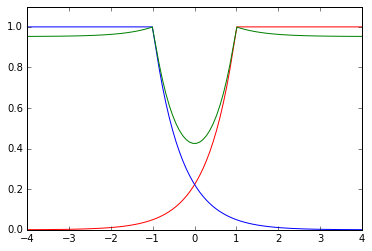

In [9]:
x = np.linspace(-4,4,100)
plt.plot(x,np.exp(-C*l(x)),color='red')
plt.plot(x,np.exp(-C*l(-x)),color='blue')
plt.plot(x,(np.exp(-C*l(x))+np.exp(-C*l(-x)))/(1+np.exp(-2*C)),color='green')
plt.ylim([0,1.1])

It is significant that the maximum points of the green function are precisely the **support vectors**.

Ok, let's run the simulation:

In [25]:
K_C = 1/(1+np.exp(-2*C))
for i in range(N*1000):
    x_rand = np.random.rand(N,2)
    theta_rand = np.random.multivariate_normal([0]*N,kernel(x_rand,x_rand))
    nu_C = K_C*(np.exp(-C*l(theta_rand))+np.exp(-C*l(-theta_rand)))
    if np.log(np.random.rand()) < np.sum(np.log(nu_C)):
        print("success at %d, with prob. %.5f"%(i,np.prod(nu_C)))
        break
y_rand = np.random.binomial([1]*N,K_C*np.exp(-C*l(theta_rand))/nu_C)

success at 375, with prob. 0.02416


Now let's plot it!

<a list of 6 text.Text objects>

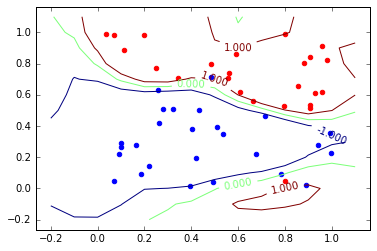

In [26]:
#Plot the data points
plt.scatter(x_rand[y_rand==0,0],x_rand[y_rand==0,1],color='blue')
plt.scatter(x_rand[y_rand==1,0],x_rand[y_rand==1,1],color='red')

#Plot the expected value for theta
delta = 0.1
x = np.arange(-0.2, 1.2, delta)
y = np.arange(-.2, 1.2, delta)
X, Y = np.meshgrid(x, y)
Z_long = kernel(np.concatenate((X.reshape(-1,1),Y.reshape(-1,1)),axis=1),x_rand).dot(\
            np.linalg.inv(kernel(x_rand,x_rand)).dot(theta_rand))
Z = Z_long.reshape(X.shape)

CS = plt.contour(X, Y, Z,levels = [-1,0,1])
plt.clabel(CS, inline=1, fontsize=10)

It's worthwhile to plot a color-coded histogram of our sampled values of theta, along with the probabilities of being red/blue, and the green function (whose peaks denote *support vectors*).

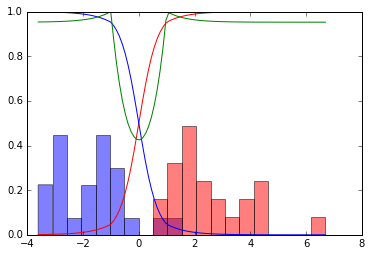

In [27]:
min_x = theta_rand.min()
max_x = theta_rand.max()
x = np.linspace(min_x,max_x,100)
plt.hist(theta_rand[y_rand==0],normed=True,color='blue',alpha=0.5,range=[min_x,max_x],bins=20)
plt.hist(theta_rand[y_rand==1],normed=True,color='red',alpha=0.5,range=[min_x,max_x],bins=20)
plt.plot(x,np.exp(-C*l(x))/(np.exp(-C*l(x))+np.exp(-C*l(-x))),color='red')
plt.plot(x,np.exp(-C*l(-x))/(np.exp(-C*l(x))+np.exp(-C*l(-x))),color='blue')
plt.plot(x,(np.exp(-C*l(x))+np.exp(-C*l(-x)))*K_C,color='green')
